# Preprocess datasets

In [2]:
# Imports

import os
import re
import json
import nltk
import spacy
import random
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
from nltk import word_tokenize
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
from nltk.corpus import stopwords

nltk.download('punkt')


# Constants

RAW_DATA_PATH = "../data/raw/"
PREPROCESSED_DATA_PATH = "../data/processed/"

[nltk_data] Downloading package punkt to
[nltk_data]     /home/flavio.merenda@EXPERT.AI/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Webis

In [ ]:
def load_webis(annotation_path, articles_path):
    # overview: XML,portal,orientation,veracity,url
    annotation_df = pd.read_csv(annotation_path)
    webis_data = []
    for _, anno in annotation_df.iterrows():
        # read xml file
        article = {}
        article['id'] = anno['XML']
        article['portal'] = anno['portal']
        article['political_orientation'] = anno['orientation']
        article['veracity_label'] = anno['veracity']
        with open("{}/{}".format(articles_path, anno['XML'])) as fp:
            xml = BeautifulSoup(fp)

            article['text'] = xml.find('maintext').text.encode('utf8').decode('utf8')
            article['author'] = xml.find('author').text
            article['title'] = xml.find('title').text
        webis_data += article,

    return webis_data

In [ ]:
def filter_short_webis(data):
    return [data for data in data if len(word_tokenize(data['text'])) >= 5]

In [ ]:
webis_annotation = os.path.join(RAW_DATA_PATH, 'webis/overview.csv')
webis_article_path = os.path.join(RAW_DATA_PATH, 'webis/articles')
webis_articles = load_webis(webis_annotation, webis_article_path)
filtered_webis_articles = filter_short_webis(webis_articles)

In [ ]:
webis_df = pd.DataFrame.from_records(filtered_webis_articles)
webis_df.shape

In [ ]:
# create a list of our conditions
conditions = [
    (webis_df["veracity_label"] == "mostly true"),
    (webis_df["veracity_label"] != "mostly true")
]

# create a list of the values we want to assign for each condition
values = ["true", "fake"]

webis_df["labels"] = np.select(conditions, values)
preprocessed_webis_df = webis_df[["text", "labels"]]
preprocessed_webis_df.shape

In [ ]:
preprocessed_webis_df.head()

In [ ]:
preprocessed_webis_df["labels"].hist()

In [ ]:
preprocessed_webis_df.to_csv(f"{PREPROCESSED_DATA_PATH}webis.csv", index=False, header=True)

## Basil

In [ ]:
BASIL_PATH = f"{RAW_DATA_PATH}basil/emnlp19-media-bias-master/emnlp19-BASIL/data/"

In [ ]:
f_names = [f_name for f_name in listdir(BASIL_PATH) if isfile(join(BASIL_PATH, f_name))]

nlp = spacy.load("en_core_web_sm")

ent2text = {
    "PERSON": "person",
    "NORP": "group",
    "FAC": "facilities",
    "ORG": "organizations",
    "GPE": "country",
    "LOC": "location",
    "PRODUCT": "product",
    "EVENT": "event",
    "WORK_OF_ART": "art",
    "LAW": "law",
    "LANGUAGE": "language",
    "DATE": "date",
    "TIME": "time",
    "PERCENT": "percentage",
    "MONEY": "money",
    "QUANTITY": "quantity",
    "ORDINAL": "number",
    "CARDINAL": "number"
}

In [ ]:
def replace_ne_with_special_token(text, nlp):
    doc = nlp(text)
    ents = [(ent.text, ent.label_) for ent in doc.ents]
    for ent in ents:
        text = text.replace(ent[0], ent2text[ent[1]])
    return text

In [ ]:
# read all files and save as Array[ sentence objects ]
all_sent_objs = []
for name in tqdm(f_names, total=len(f_names)):
    path = join(BASIL_PATH, name)
    with open(path, 'r') as json_file:
        data = json.load(json_file)

        meta_obj = {'main-event': data['main-event'], 'title': data['title'], 'article_id': name}
        for sent_obj in data['body']:
            sent_obj.update(meta_obj)
            sent_obj['ne_text'] = replace_ne_with_special_token(sent_obj['sentence'], nlp)

            all_sent_objs.append(sent_obj)

bias_type_basil = []
for sent_obj in all_sent_objs:
    # if there exists annotation for bias
    anno_count = len(sent_obj['annotations'])
    if anno_count == 0:
        sent_obj['label'] = 'no-bias'
    elif anno_count == 1:
        sent_obj['label'] = sent_obj['annotations'][0]['bias']
    elif anno_count > 1:
        bias_type = list(set([anno['bias'] for anno in sent_obj['annotations']]))
        if len(bias_type) == 1:
            sent_obj['label'] = bias_type[0]
        else:
            sent_obj['label'] = "both"
    bias_type_basil.append(sent_obj)

In [ ]:
def filter_short_basil(data):
    return [data for data in data if len(word_tokenize(data['sentence'])) >= 5]

In [ ]:
filtered_basil = filter_short_basil(bias_type_basil)
basil_df = pd.DataFrame.from_records(filtered_basil)
basil_df.shape

In [ ]:
# create a list of our conditions
conditions = [
    (basil_df["label"] == "no-bias"),
    (basil_df["label"] != "no-bias")
]

# create a list of the values we want to assign for each condition
values = ["no-bias", "contains-bias"]

basil_df["labels"] = np.select(conditions, values)
basil_df.rename(columns = {"sentence": "text"}, inplace = True)
preprocessed_basil_df = basil_df[["text", "labels"]]
preprocessed_basil_df.shape

In [ ]:
preprocessed_basil_df.head()

In [ ]:
preprocessed_basil_df["labels"].hist()

In [ ]:
preprocessed_basil_df.to_csv(f"{PREPROCESSED_DATA_PATH}basil.csv", index=False, header=True)

## Clickbait

In [ ]:
TRUTH_PATH = f"{RAW_DATA_PATH}clickbait/clickbait17-validation-170630/truth.jsonl"
INSTANCES_PATH = f"{RAW_DATA_PATH}clickbait/clickbait17-validation-170630/instances.jsonl"

In [ ]:
with open(TRUTH_PATH, 'r') as label_file:
    label_list = [json.loads(item) for item in list(label_file)]
    id2label_dict = {item['id']:item['truthClass'] for item in label_list}

In [ ]:
with open(INSTANCES_PATH, 'r') as json_file:
    data_list = [json.loads(item) for item in list(json_file)]

In [ ]:
new_clickbait_data = []
for data in data_list:
    data['label'] = id2label_dict[data['id']]
    new_clickbait_data.append(data)

In [ ]:
def clean_txt(text,
    remove_stopwords=False,
    remove_nonalphanumeric=False,
    use_number_special_token=False,
    remove_numbers=False,
    separate_contractions=False
):

    text = text.lower()
    if separate_contractions:
        text = re.sub(r"\'s", " \'s", text)
        text = re.sub(r"\'ve", " \'ve", text)
        text = re.sub(r"n\'t", " n\'t", text)
        text = re.sub(r"\'re", " \'re", text)
        text = re.sub(r"\'d", " \'d", text)
        text = re.sub(r"\'ll", " \'ll", text)

    text = re.sub(r"-", " ", text)
    text = re.sub(r"[a-zA-Z]+\/[a-zA-Z]+", " ", text)
    text = re.sub(r"\n", " ", text)

    if remove_nonalphanumeric:
        text = re.sub(r'([^\s\w\']|_)+', " ", text)

    if use_number_special_token:
        text = re.sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>", text)
    elif remove_numbers:
        text = re.sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "", text)

    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if w not in stops]
        text = " ".join(text)

    # Remove URL
    text = re.sub(r"(http)\S+", "", text)
    text = re.sub(r"(www)\S+", "", text)
    text = re.sub(r"(href)\S+", "", text)
    # Remove multiple spaces
    text = re.sub(r"[ \s\t\n]+", " ", text)

    # remove repetition
    text = re.sub(r"([!?.]){2,}", r"\1", text)
    text = re.sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2", text)

    return text.strip()

In [ ]:
def filter_short_clickbait(data):
    return [d for d in data if len(word_tokenize(clean_txt(" ".join(d['postText'])))) >= 5]

In [ ]:
filtered_clickbait_data = filter_short_clickbait(new_clickbait_data)

In [ ]:
for row in tqdm(filtered_clickbait_data):
    row.update({'postText': " ".join(row['postText'])})

In [ ]:
clickbait_df = pd.DataFrame.from_records(filtered_clickbait_data)
clickbait_df.shape

In [ ]:
clickbait_df

In [ ]:
clickbait_df.rename(columns = {"postText": "text"}, inplace = True)
clickbait_df.rename(columns = {"label": "labels"}, inplace = True)
preprocessed_clickbait_df  = clickbait_df[["text", "labels"]]

In [ ]:
preprocessed_clickbait_df.head()

In [ ]:
preprocessed_clickbait_df["labels"].hist()

In [ ]:
preprocessed_clickbait_df.to_csv(f"{PREPROCESSED_DATA_PATH}clickbait.csv", index=False, header=True)

## Pheme

In [ ]:
PHEME_PATH = f"{RAW_DATA_PATH}pheme/all-rnr-annotated-threads"

In [ ]:
'''convertion code from PHEME creators. Label: True = rumour is true. False = rumour is false'''
def convert_annotations(annotation, string = True):
    if 'misinformation' in annotation.keys() and 'true'in annotation.keys():
        if int(annotation['misinformation'])==0 and int(annotation['true'])==0:
            if string:
                label = "unverified"
            else:
                label = 2
        elif int(annotation['misinformation'])==0 and int(annotation['true'])==1 :
            if string:
                label = "true"
            else:
                label = 1
        elif int(annotation['misinformation'])==1 and int(annotation['true'])==0 :
            if string:
                label = "false"
            else:
                label = 0
        elif int(annotation['misinformation'])==1 and int(annotation['true'])==1:
            print ("OMG! They both are 1!")
            print(annotation['misinformation'])
            print(annotation['true'])
            label = None
            
    elif 'misinformation' in annotation.keys() and 'true' not in annotation.keys():
        # all instances have misinfo label but don't have true label
        if int(annotation['misinformation'])==0:
            if string:
                label = "unverified"
            else:
                label = 2
        elif int(annotation['misinformation'])==1:
            if string:
                label = "false"
            else:
                label = 0
                
    elif 'true' in annotation.keys() and 'misinformation' not in annotation.keys():
        print ('Has true not misinformation')
        label = None
    else:
        print('No annotations')
        label = None
           
    return label

In [ ]:
thread_info = {}
events = [d for d in os.listdir(PHEME_PATH) if not d.startswith('.')]
for event in tqdm(events):
    threads = [d for d in os.listdir('{}/{}'.format(PHEME_PATH, event))]
    print(event, len(threads))

    rumour_threads = [d for d in os.listdir('{}/{}/rumours'.format(PHEME_PATH, event)) if not d.startswith('.')]
    non_rumour_threads = [d for d in os.listdir('{}/{}/non-rumours'.format(PHEME_PATH, event))]

    for r_id in rumour_threads:
        # process lvl2 rumour veracity annotation (true, false, unverified rumour)
        with open('{}/{}/rumours/{}/annotation.json'.format(PHEME_PATH, event, r_id)) as json_file:
            # anno fields: links - evidences/information about the rumour. category - rumour type. 
            # misinfo & true lables are used to determine labels for each thread
            anno = json.load(json_file)
            veracity_label = convert_annotations(anno)
            evidence_arr = anno['links']
            rumour_category = anno['category'] # TODO check what this is later 

        # combine lvl1 rumour detection labels with lvl2 labels
        thread_info[r_id] = {
            'thread_id': r_id,
            'rumour_label': 'rumour',
            'veracity_label': veracity_label,
            'evidence': evidence_arr,
            'rumour_category': rumour_category
        }

    for r_id in non_rumour_threads:
        # non-rumour doesn't have lvl2 annotation.
        thread_info[r_id] = {'thread_id': r_id, 'rumour_label':'non-rumour'}
    
    event_name = event.split('-')[0]

In [ ]:
def process_id2text(threads, lvl_1_path, id2text):
    for r_id in threads:
        # for each rumour_thead, there is ONE source-tweet, and MULTIPLE reations

        # {base}/{event}/{rumours or non-rumour)}/{thread-id}/source-tweets/{rumour-id}.json
        with open('{}/{}/{}/{}/source-tweets/{}.json'.format(PHEME_PATH, event, lvl_1_path, r_id, r_id)) as json_file:
            tweet_json = json.load(json_file)
            id2text[tweet_json['id_str']] = tweet_json['text']
            
        reaction_tweets = [d for d in os.listdir('{}/{}/{}/{}/reactions'.format(PHEME_PATH, event, lvl_1_path, r_id))
                          if 'json' in d and not d.startswith('.')]
        for r_tweet_id in reaction_tweets:
            with open('{}/{}/{}/{}/reactions/{}'.format(PHEME_PATH, event, lvl_1_path, r_id, r_tweet_id)) as json_file:
                tweet_json = json.load(json_file)
                id2text[tweet_json['id_str']] = tweet_json['text']
                
    return id2text

In [ ]:
events = [d for d in os.listdir(PHEME_PATH) if not d.startswith('.')]
id2text = {}

for event in tqdm(events):
    threads = [d for d in os.listdir('{}/{}'.format(PHEME_PATH, event))]

    rumour_threads = [d for d in os.listdir('{}/{}/rumours'.format(PHEME_PATH, event)) if not d.startswith('.')]
    non_rumour_threads = [d for d in os.listdir('{}/{}/non-rumours'.format(PHEME_PATH, event)) if not d.startswith('.')]

    id2text = process_id2text(rumour_threads, 'rumours', id2text)
    id2text = process_id2text(non_rumour_threads, 'non-rumours', id2text)

In [ ]:
rumour_data = [thread_info[key] for key in thread_info if thread_info[key]['rumour_label'] == 'rumour']

# filter 'unverified'
filtered_rumour_data = []
for d in rumour_data:
    if d['veracity_label'] == 'unverified':
        continue
    else:
        filtered_rumour_data.append(d)

In [ ]:
processed_rumor_data = [
    {
        "tweet_id": item['thread_id'],
        "text": id2text[item['thread_id']],
        "labels": item["veracity_label"]
    } for item in filtered_rumour_data
]

In [ ]:
pheme_df = pd.DataFrame.from_records(processed_rumor_data)
pheme_df.shape

In [ ]:
pheme_df

In [ ]:
preprocessed_pheme_df  = pheme_df[["text", "labels"]]
preprocessed_pheme_df.head()

In [ ]:
preprocessed_pheme_df["labels"].hist()

In [ ]:
preprocessed_pheme_df.to_csv(f"{PREPROCESSED_DATA_PATH}pheme.csv", index=False, header=True)

## Polifact

In [18]:
politifact_dir = '{}fakenewsnet/FakeNewsNetCleaned-master/Data/PolitiFact'.format(RAW_DATA_PATH)

real_dir = '{}/RealNewsContent'.format(politifact_dir)
fake_dir = '{}/FakeNewsContent'.format(politifact_dir)

real_data, fake_data = [], []
for file_path in [join(real_dir, f) for f in listdir(real_dir) if isfile(join(real_dir, f))]:
    with open(file_path) as json_file:
        obj = json.load(json_file)
        obj['labels'] = 'real'
        real_data.append(obj)

for file_path in [join(fake_dir, f) for f in listdir(fake_dir) if isfile(join(fake_dir, f))]:
    with open(file_path) as json_file:
        obj = json.load(json_file)
        obj['labels'] = 'fake'
        fake_data.append(obj)

all_data = fake_data + real_data
np.random.shuffle(all_data)
politifact_df = pd.DataFrame.from_dict(all_data)
politifact_df = politifact_df[["text", "labels"]]

In [19]:
politifact_df

,text,labels
0,"Detroit, MI | A Michigan elector, in a surge o...",fake
1,"Police in Vernal Heights, Florida, arrested 3-...",fake
2,A highly regarded Texas law enforcement office...,fake
3,Need more proof that liberalism is a disease? ...,fake
4,"COSTA MESA, Ca. – GOP presidential front-runne...",fake
...,...,...
198,A ninety-six-year-old World War II veteran and...,real
199,Gretchen Carlson is renewing her push for an A...,fake
200,"As we promised, Freedom Crossroads has just le...",fake
201,"According to guerilla:\n\nObama Canceled It, T...",fake


In [20]:
politifact_df["labels"].value_counts()

labels
real    111
fake     92
Name: count, dtype: int64

In [ ]:
politifact_df["labels"].hist()

In [ ]:
politifact_df.to_csv(f"{PREPROCESSED_DATA_PATH}politifact.csv", index=False, header=True)

## Buzzfeed

In [21]:
buzzfeed_dir = '{}fakenewsnet/FakeNewsNetCleaned-master/Data/BuzzFeed'.format(RAW_DATA_PATH)

real_dir = '{}/RealNewsContent'.format(buzzfeed_dir)
fake_dir = '{}/FakeNewsContent'.format(buzzfeed_dir)

real_data, fake_data = [], []
for file_path in [join(real_dir, f) for f in listdir(real_dir) if isfile(join(real_dir, f))]:
    with open(file_path) as json_file:
        obj = json.load(json_file)
        obj['labels'] = 'real'
        real_data.append(obj)

for file_path in [join(fake_dir, f) for f in listdir(fake_dir) if isfile(join(fake_dir, f))]:
    with open(file_path) as json_file:
        obj = json.load(json_file)
        obj['labels'] = 'fake'
        fake_data.append(obj)

all_data = fake_data + real_data
np.random.shuffle(all_data)
buzzfeed_df = pd.DataFrame.from_dict(all_data)
buzzfeed_df = buzzfeed_df[["title", "labels"]]
buzzfeed_df.rename(columns = {'title':'text'}, inplace = True)

In [22]:
buzzfeed_df

,text,labels
0,Pence gives no specifics on why Trump Foundati...,real
1,Bridgegate: Port Authority officials planned t...,real
2,The Pope Flat Out Called Fox News Type Journal...,fake
3,CHAOS! NC Protest MOB Ambushes Female Truck Dr...,real
4,"SICK! Muslim Refugee Beats, Urinates On Pregna...",fake
...,...,...
165,Donald Trump retreats to friendly media ground,real
166,Clinton vs. Trump: The debate before the debate,real
167,Everything you need to know about Trump and Cl...,real
168,Californians Had Special Way to View the Eclip...,fake


In [23]:
buzzfeed_df["labels"].value_counts()

labels
real    90
fake    80
Name: count, dtype: int64

<Axes: >

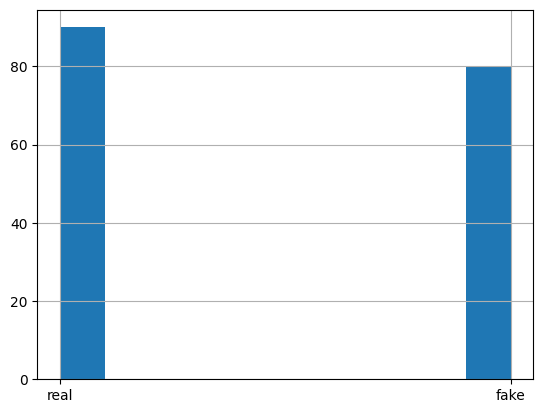

In [24]:
buzzfeed_df["labels"].hist()

In [5]:
buzzfeed_df.to_csv(f"{PREPROCESSED_DATA_PATH}buzzfeed.csv", index=False, header=True)

## Propaganda

In [3]:
path = f'{RAW_DATA_PATH}propaganda/code/data/protechn_corpus_eval'

def read_and_process_files(phase='test', save_path=PREPROCESSED_DATA_PATH):
    full_path="{}/{}".format(path, phase)

    txt_onlyfiles = [f for f in listdir(full_path) if ".txt" in f]
    all_data = []

    for idx, txt_path in enumerate(txt_onlyfiles):
        try:
            label_path_ = "{}/{}".format(full_path, txt_path.split('.')[0] + ".labels.tsv")
            labels = pd.read_csv(label_path_, sep='\t')

            with open("{}/{}".format(full_path, txt_path), 'r') as txt_in_f:
                text = txt_in_f.read()

            indices = []
            for label_row in labels.iterrows():
                indices.append((label_row[1][2],label_row[1][3]))

            indices = sorted(indices, key=lambda item: item[0]) 
            to_find_phrases = [text[s:e] for (s,e) in indices if len(text[s:e].strip()) > 3]
            candidates = text.split(".")
            candidate_idx, to_find_idx = 0, 0

            found_og_sents = []
            discard_sents = []
            while candidate_idx < len(candidates) and to_find_idx < len(to_find_phrases):
                if to_find_phrases[to_find_idx] in candidates[candidate_idx]:
                    found_og_sents.append(candidates[candidate_idx])
                    to_find_idx += 1
                else:
                    discard_sents.append(candidates[candidate_idx])
                candidate_idx+=1
            
            propaganda_samples = [{'text': sent, 'labels': 'has_propaganda'} for sent in found_og_sents]
            all_data.extend(propaganda_samples)

            random.shuffle(discard_sents)
            negative_samples = discard_sents[:len(found_og_sents)]
            non_propaganda_samples = [{'text': sent, 'labels': 'no_propaganda'} for sent in negative_samples]
            all_data.extend(non_propaganda_samples)
        except:
            continue

    
    np.random.shuffle(all_data)
    return all_data

In [5]:
propaganda_train = read_and_process_files('train')
propaganda_dev = read_and_process_files('dev')
propaganda_test = read_and_process_files('test')

In [6]:
propaganda_df = pd.DataFrame.from_dict(propaganda_train+propaganda_dev+propaganda_test)

In [15]:
propaganda_df

,text,labels
0,”\nAmong the measures taken by SSMU after the ...,no_propaganda
1,\nDB: What would you say have been the contrib...,no_propaganda
2,\nFarrakhan’s history of racially extreme comm...,has_propaganda
3,,no_propaganda
4,\nWhat started after the 2016 election as a re...,has_propaganda
...,...,...
1617,"\nTake a look, and as always, PJW is hilarious...",no_propaganda
1618,"""\n""There is simply no way of telling how much...",has_propaganda
1619,\nThe incubation period is extremely short too...,has_propaganda
1620,"\nNo, you can't act like a child and keep your...",no_propaganda


In [17]:
propaganda_df["labels"].value_counts()

labels
has_propaganda    816
no_propaganda     806
Name: count, dtype: int64

<Axes: >

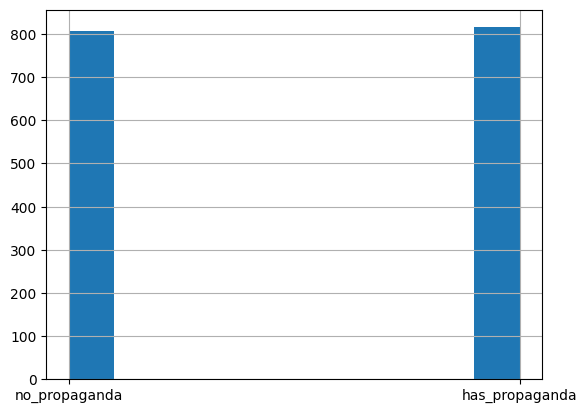

In [16]:
propaganda_df["labels"].hist()

In [ ]:
propaganda_df.to_csv(f"{PREPROCESSED_DATA_PATH}propaganda.csv", index=False, header=True)

## TwitterCovid

In [25]:
twitter_covid_data_path = f'{RAW_DATA_PATH}twittercovid/data/English/covid19_infodemic_english_data.tsv'

In [26]:
data_df = pd.read_csv(twitter_covid_data_path, sep='\t')

In [27]:
q1_df = data_df.loc[:, 'text': 'q1_label']
q2_df = data_df.loc[:, 'text': 'q2_label']

# filter any NAN label rows
q1_df = q1_df.dropna()
q2_df = q2_df.dropna()

print("data sizes:", len(q1_df), len(q2_df))

data sizes: 504 305


In [28]:
q1_df["labels"] = q1_df["q1_label"]
twittercovidq1 = q1_df[["text", "labels"]]

In [29]:
twittercovidq1["labels"].value_counts()

labels
yes    305
no     199
Name: count, dtype: int64

In [30]:
label_map = {
    "1_no_definitely_contains_no_false_info": "no_false",
    "2_no_probably_contains_no_false_info": "no_false",
    "3_not_sure": "N/A",
    "4_yes_probably_contains_false_info": "contains_false",
    "5_yes_definitely_contains_false_info": "contains_false",
}

new_data = []
for item in q2_df.to_dict("records"):
    text_label = item['q2_label']
    if text_label == "3_not_sure":
        continue  # skip
    else:
        label = label_map[text_label]
        text = item['text']
        new_data.append({"text": text, "labels": label})

In [32]:
twittercovidq2 = pd.DataFrame.from_dict(new_data)

In [33]:
twittercovidq2["labels"].value_counts()

labels
no_false          223
contains_false     37
Name: count, dtype: int64

In [ ]:
twittercovidq1.to_csv(f"{PREPROCESSED_DATA_PATH}twittercovidq1.csv", index=False, header=True)
twittercovidq2.to_csv(f"{PREPROCESSED_DATA_PATH}twittercovidq2.csv", index=False, header=True)